In [2]:
from sys import version

print(version)
print("HEY")

3.8.2 (default, Mar 11 2020, 00:28:52) 
[Clang 11.0.0 (clang-1100.0.33.17)]
HEY


In [3]:
from app import AppContext, Word as WordModel
from core import LoadConfig
import numpy as np

from scipy.interpolate import griddata

from typing import *
from time import time


In [115]:
ctx = AppContext(LoadConfig("configs/main.yaml"))


class Word:
    def __init__(self, word: str,
                 t: np.ndarray = None, 
                 v: np.ndarray = None):
        self.word = word.strip().lower()
        self.t = t
        self.v = v
        if t is not None and v is not None:
            assert len(t) == len(v), (len(t), len(v))
            
    def _set_default_v(self):
        assert self.v is None
        self.t, self.v = np.unique(self.t, return_counts=True)
    
    async def download(self, period_s=60 * 60 * 24 * 30 * 6):
        word_p = []
        start_time = time() - period_s
        async for word in ctx.db.find(WordModel(word=self.word)):
            if word.date >= start_time:
                word_p.append(word.date)
        word_ts = np.array(word_p)
        self.t = word_ts
        self.t.sort()
    
    def slice(self, from_p=5, to_p=95):
        from_p_val = np.percentile(self.t, from_p)
        to_p_val = np.percentile(self.t, to_p)
        
        filter_ = (from_p_val < self.t) & (self.t < to_p_val)
        
        return Word(self.word, self.t[filter_], self.v[filter_] if self.v is not None else None) 
    
    def integrate(self):
        if self.v is None:
            self._set_default_v()
        return Word(self.word, self.t, np.cumsum(self.v))
    
    def diff(self):
        return Word(self.word,
                    (self.t[1:] + self.t[:-1]) / 2,
                    np.diff(self.v)
                    )
    
    def moving_exp(self, periods):
        periods = int(periods)
        weights = np.power(2., -np.arange(periods, 0, -1))
        weights = np.array([weights[0] / periods]) + weights
        assert weights.sum() == 1
        
        v = np.convolve(self.v, weights, mode='same')
        return Word(self.word, self.t, v)
    
    def moving_avg(self, periods):
        periods = int(periods)
        weights = np.ones((periods, )) / periods
        
        pp = periods / 2

        weights = np.append(np.arange(1, pp, 1), np.arange(pp, 0, -1))
        weights /= weights.sum()
        
        v = np.convolve(self.v, weights, mode='same')
        return Word(self.word, self.t, v)
    
    def to_grid(self, coef):
        if self.v is None:
            self._set_default_v()
            
        period = np.percentile(np.diff(self.t), 50) / coef
        count = int((self.t.max() - self.t.min()) // period or 0) + 1
        start_ = self.t.min()

        xi = np.linspace(self.t.min(), self.t.max(), num=count, dtype=int)
        assert self.t.max() == xi.max(), (self.t.max(), xi.max())
        v = np.zeros((count + 1, ), dtype=int)
        
        indexes = ((self.t - start_) // period).round().astype(int)
        
        np.add.at(v, indexes, self.v)
        
        return Word(self.word, xi, v[:-1])
        
    def get_smooth(self, coef=1, mov=True):
        result = self.slice().integrate().to_grid(coef)#.diff()
        if mov:
            result = result.moving_avg(coef * 2)
        return result
    
    def __add__(self, other: "Word"):
        assert self.v is None and other.v is None
        assert self.t is not None and other.t is not None
        return Word(f"{self.word}+{other.word}", np.append(self.t, other.t))

def update_class_word():
    for k, v in words.items():
        words[k] = Word(v.word, v.t, v.v)
update_class_word()


[2020-04-11 23:31:15.636351] [  INFO   ] /48382/ LoadConfig core/config/__init__.py:13 LoadConfig: Load config source=configs/main.yaml


In [14]:
from plotly import graph_objects as go


def draw_word(fig, word_ts: Word,
              name, opacity=None, mode=None):
    y = word_ts.v
    assert y is not None

    from datetime import datetime
    x_dt = [datetime.fromtimestamp(ts) for ts in word.t]

    fig.add_trace(go.Scatter(x=x_dt, y=y,
                             name=name, opacity=opacity,
                             mode=mode))

word = Word("нгу")
await word.download()

word = Word("test", np.array(
    [time() - 60 * 60, time(), time() + 60 * 60, time() + 60 * 60, time() + 60 * 60 * 3, time() + 60 * 60 * 3, time() + 60 * 60 * 4],
    dtype=int
))
print(word.t)

print(word.slice().t)



[1586616742 1586620342 1586623942 1586623942 1586631142 1586631142
 1586634742]
[1586620342 1586623942 1586623942 1586631142 1586631142]


In [244]:
word.slice().t

array([1586617285, 1586620885, 1586620885, 1586628085, 1586628085])

In [11]:
words = {}

async for item in ctx.db.db.Word.aggregate([
   { "$match": {}},
   { "$group": {
       "_id": "$word",
       "count": { "$sum": 1 }
   }},
   {'$sort': {'count': -1}}
]):
    name = item['_id']
    count = item['count']
    if count < 500:
        continue
    
    words[name] = Word(name)
    print(f"Download word: {name}")
    await words[name].download()

print(f"READY! Download {len(words)} words")

Download word: день
Download word: весь
Download word: все
Download word: мой
Download word: год
Download word: который
Download word: так
Download word: свой
Download word: человек
Download word: такой
Download word: очень
Download word: рождение
Download word: если
Download word: кто
Download word: мочь
Download word: вот
Download word: новый
Download word: один
Download word: себя
Download word: или
Download word: когда
Download word: самый
Download word: уже
Download word: друг
Download word: хороший
Download word: только
Download word: тот
Download word: много
Download word: она
Download word: жизнь
Download word: время
Download word: хотеть
Download word: можно
Download word: просто
Download word: чтобы
Download word: спасибо
Download word: знать
Download word: работа
Download word: первый
Download word: еще
Download word: даже
Download word: любить
Download word: сегодня
Download word: раз
Download word: нет
Download word: каждый
Download word: становиться
Download word: про
Dow

In [13]:
_words_backup_link = words
len(words)

408

In [151]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
from datetime import datetime
    
def plot(ax, word, name):
    if word.t[0] < time() / 2:
        t = word.t
    else:
        t = [datetime.fromtimestamp(ts) for ts in word.t]
    s = word.v
    
    ax.plot(t, s, label=name)

def get_ax(title):
    fig, ax = plt.subplots()

    fig.set_figwidth(15)
    fig.set_figheight(15)
    
    ax.set(xlabel='Date', ylabel='Posts/period',
           title=title)
    ax.grid()
    
    return ax
    

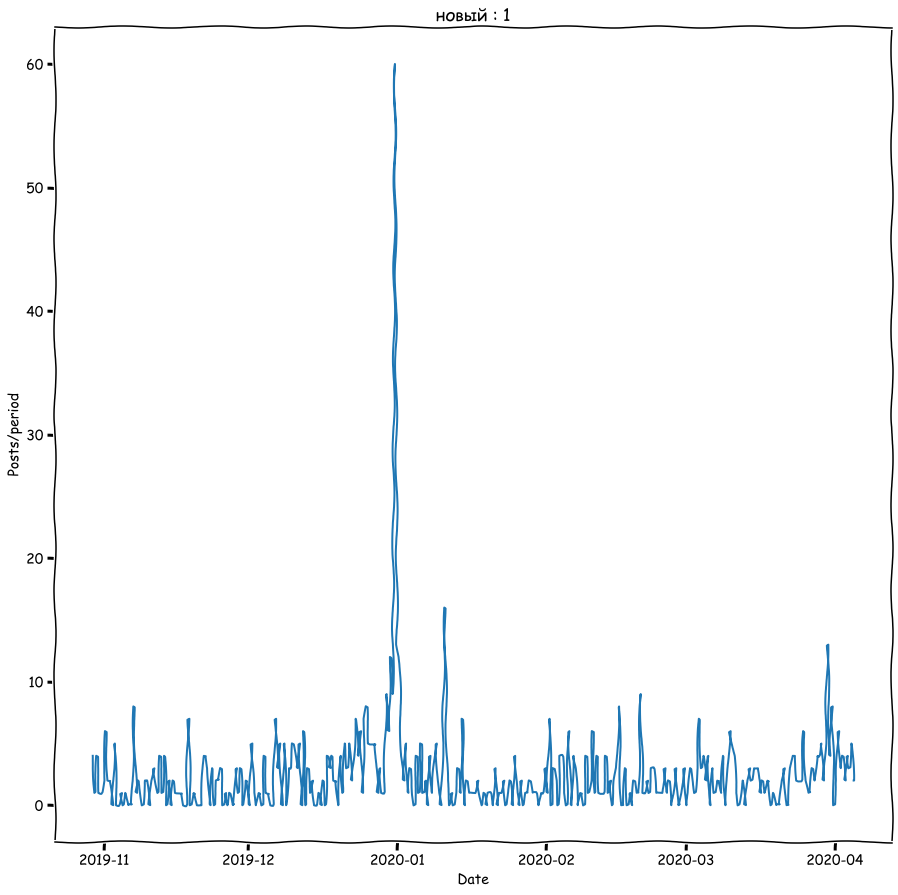

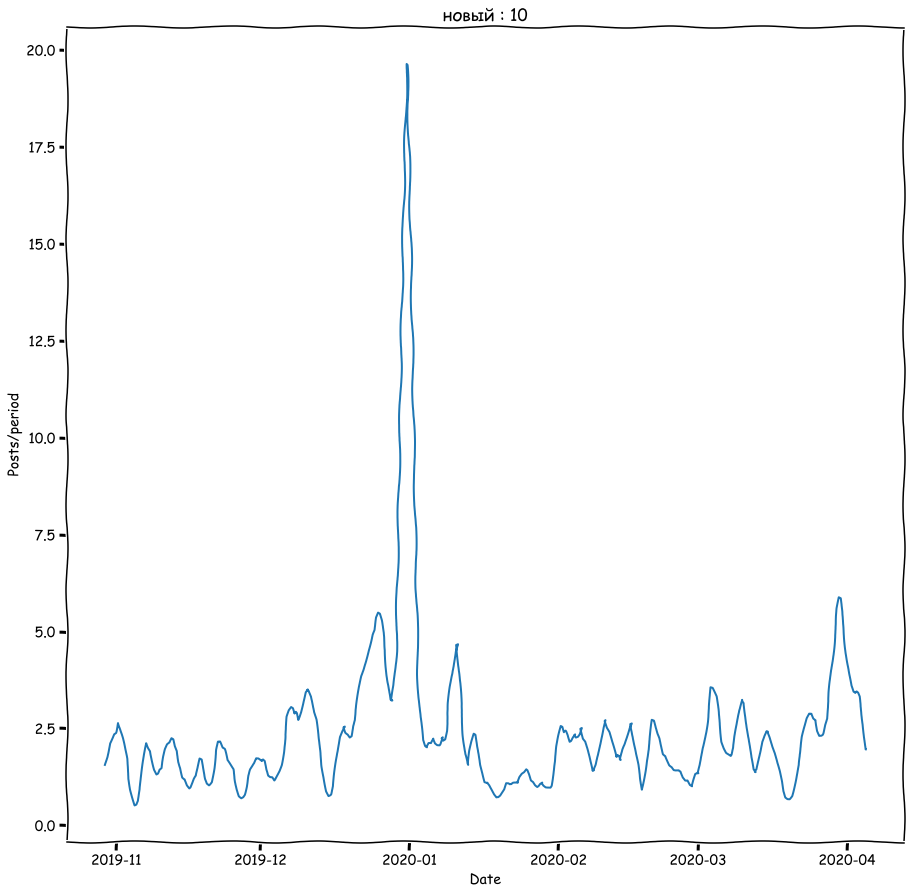

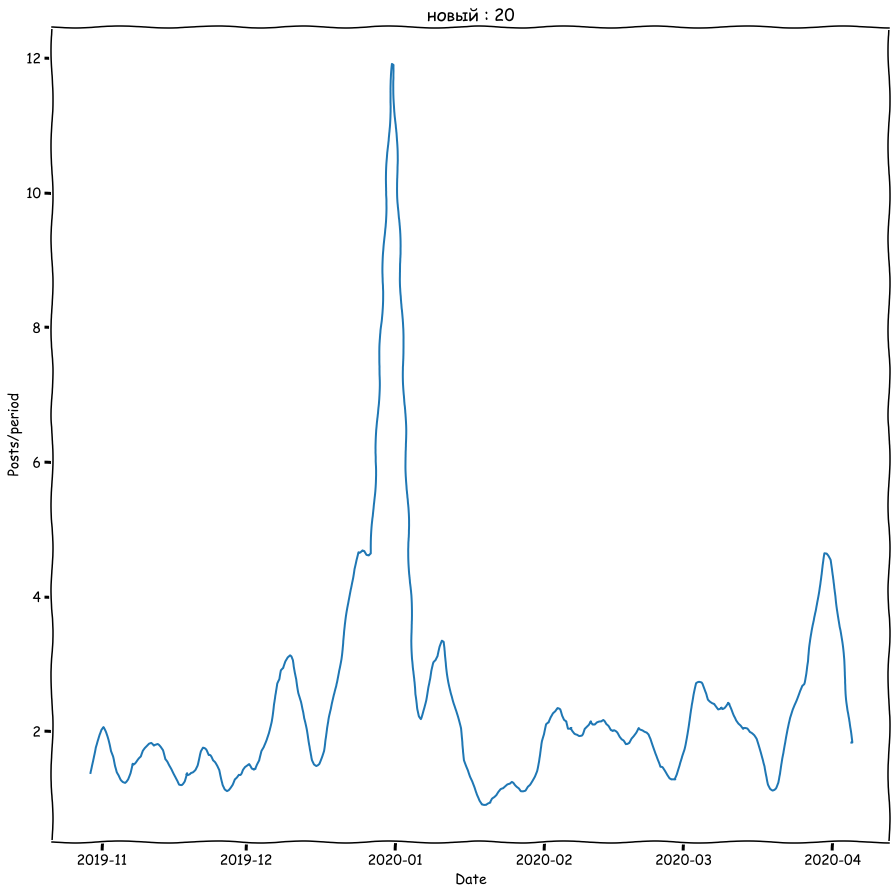

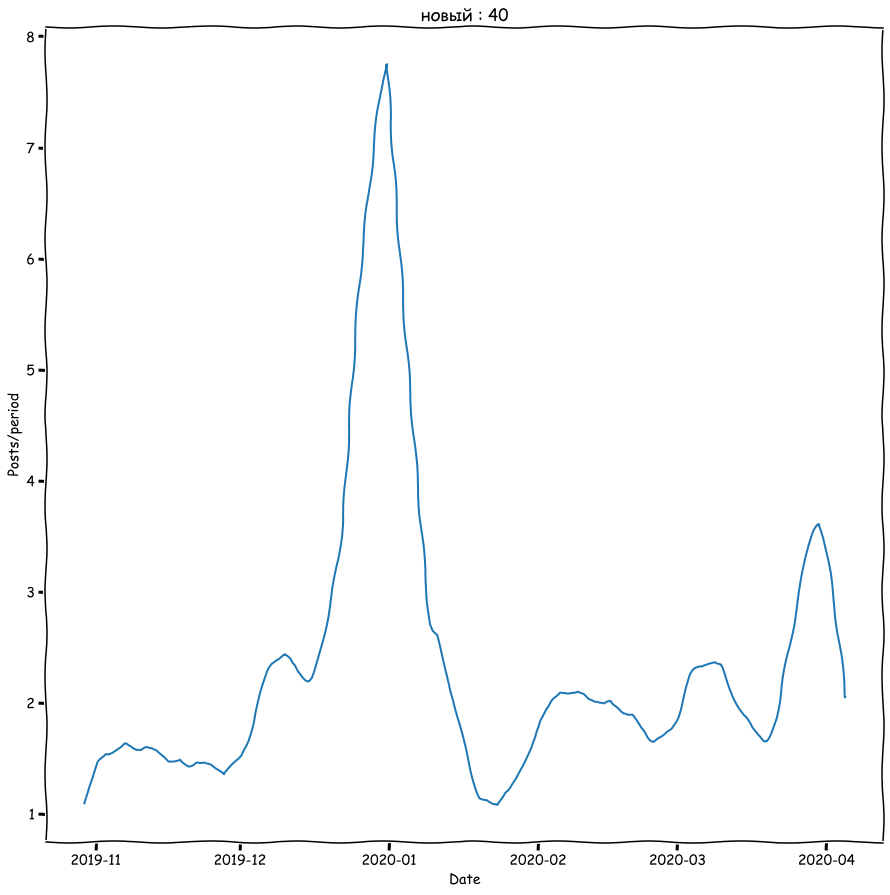

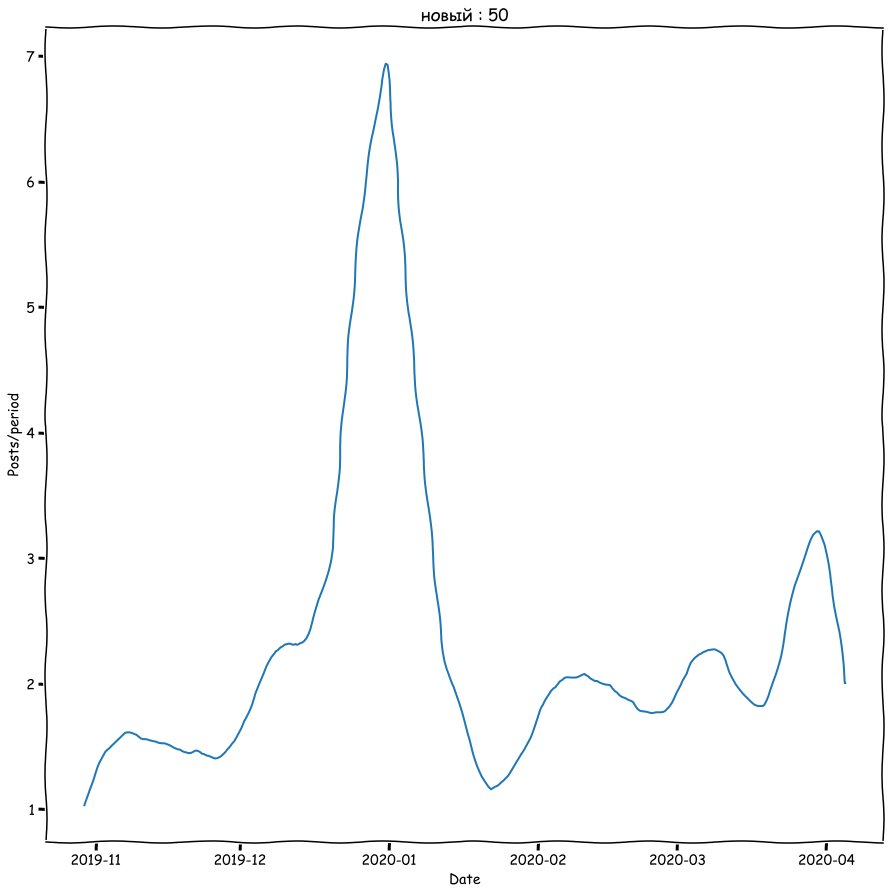

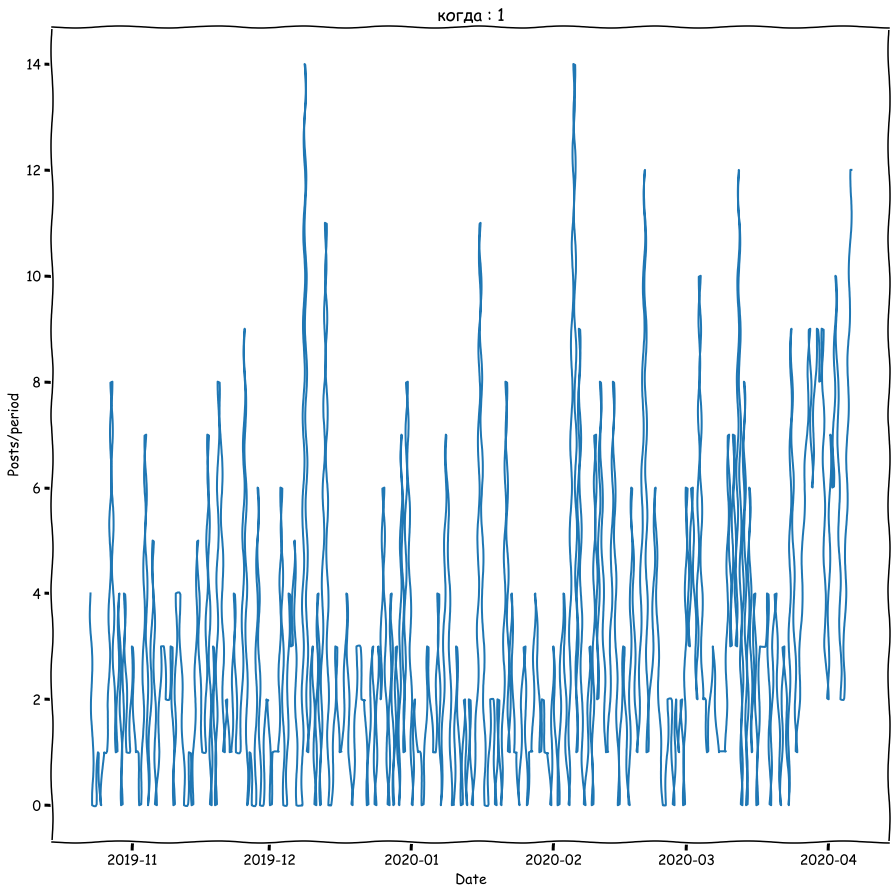

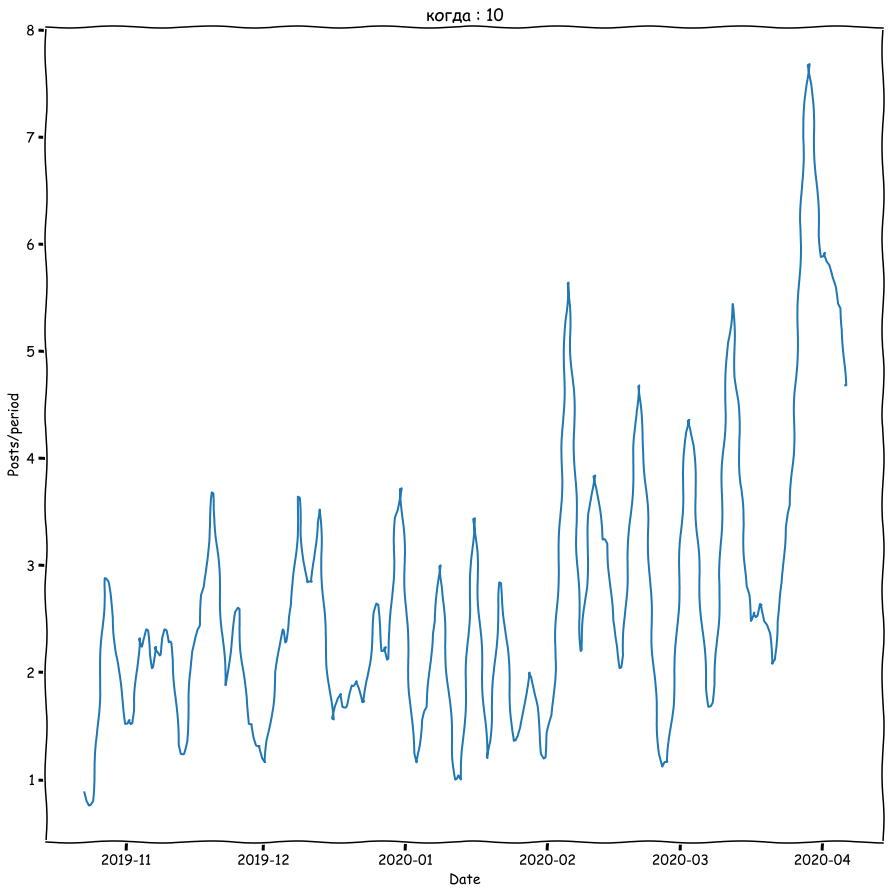

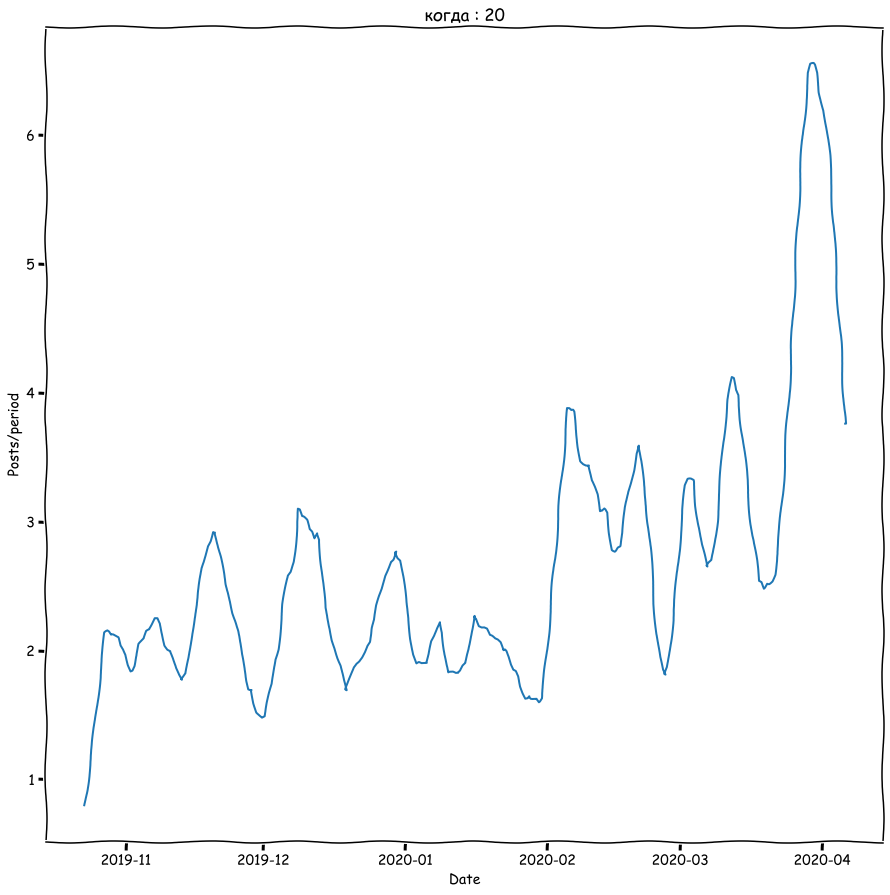

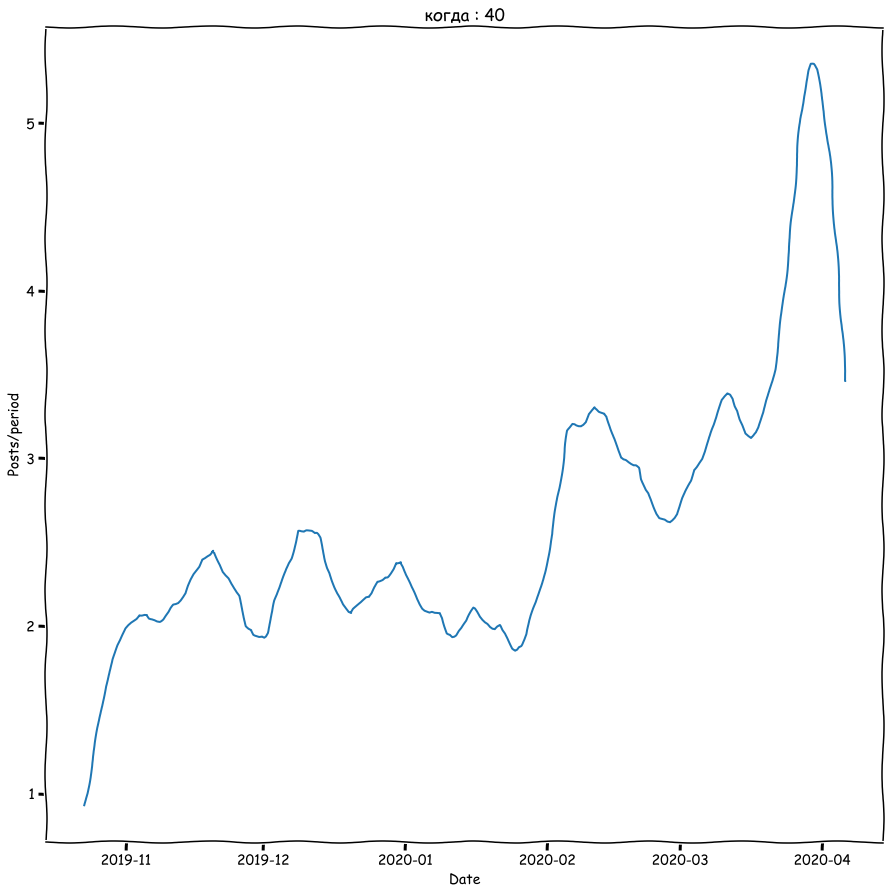

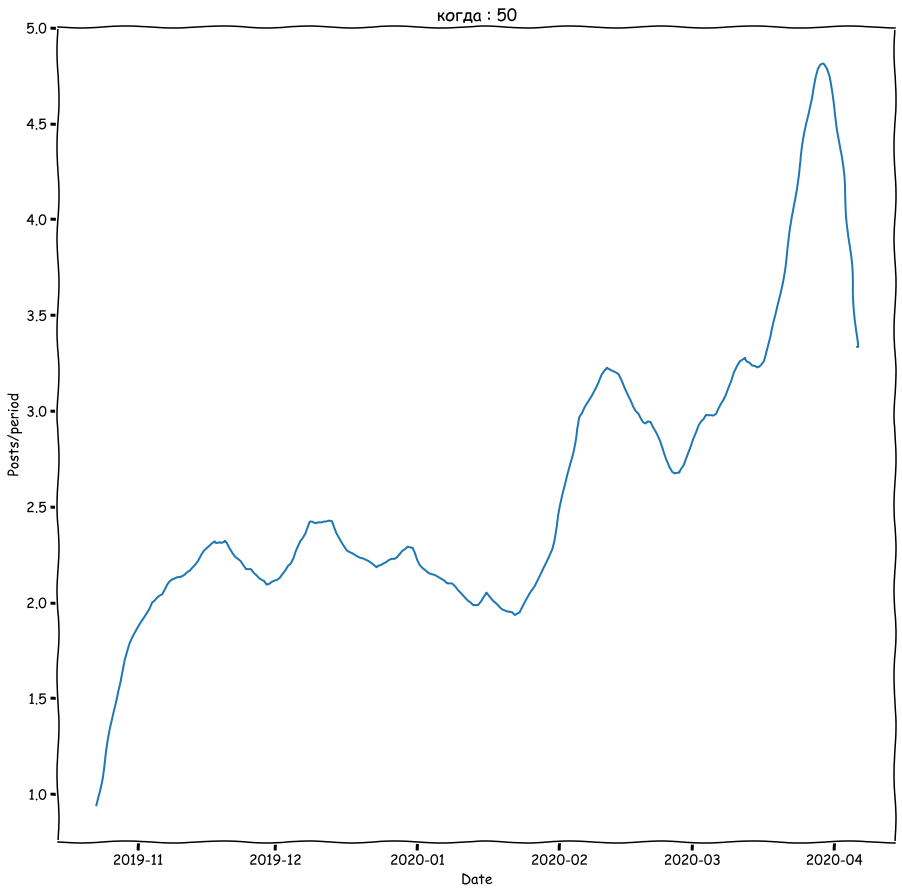

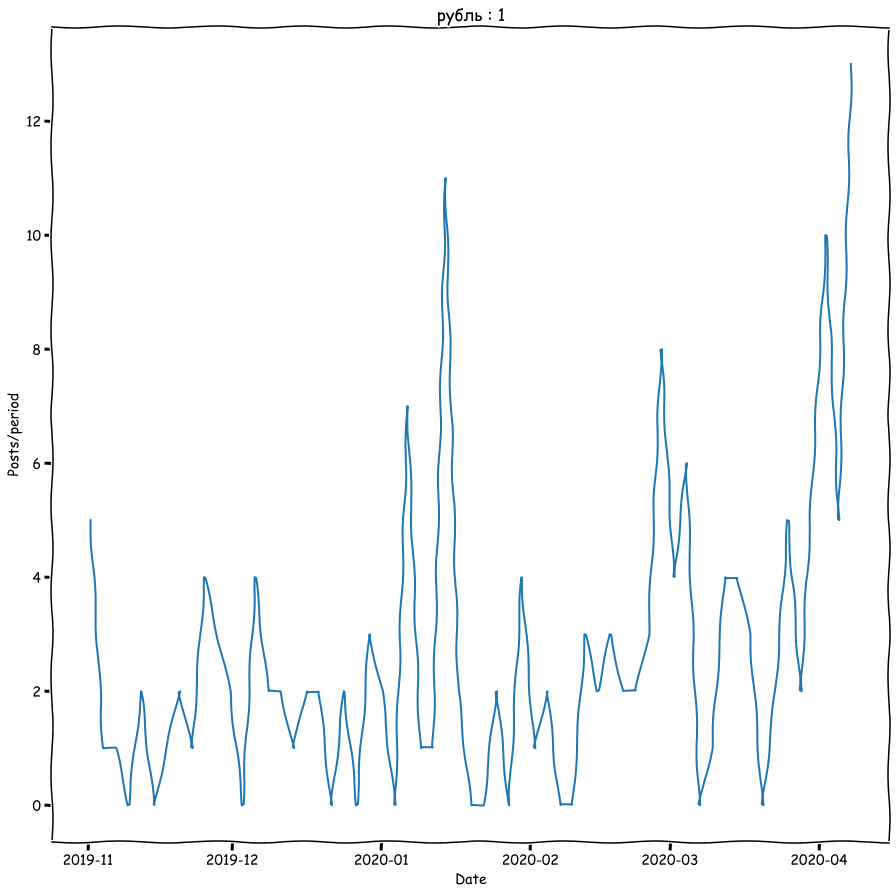

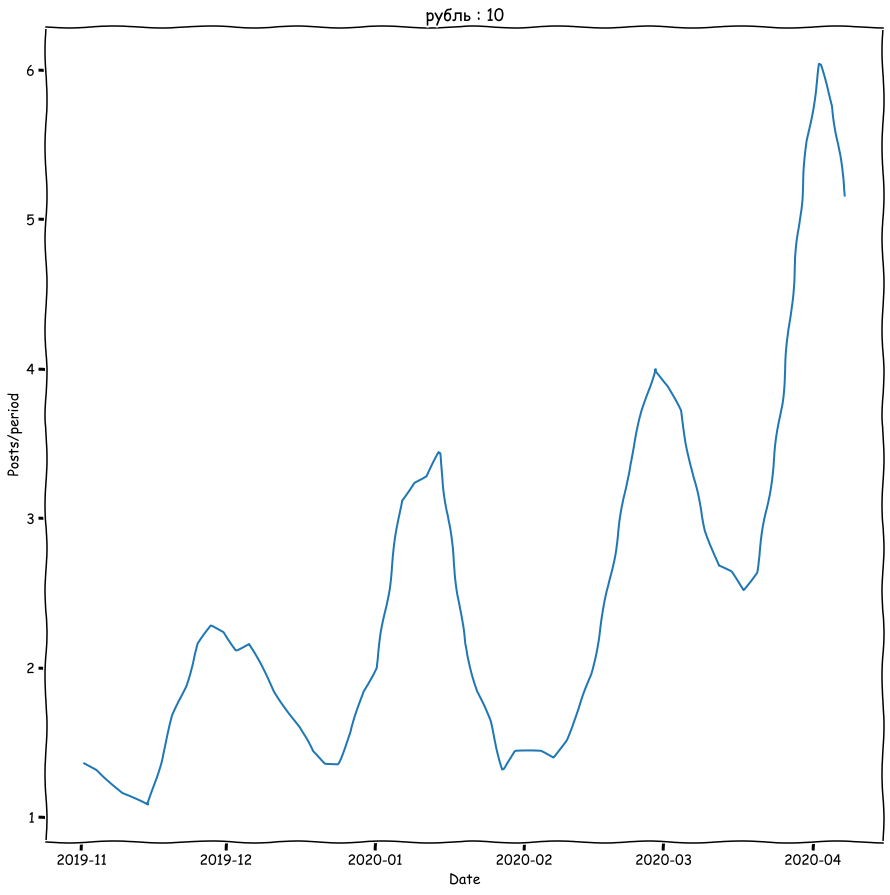

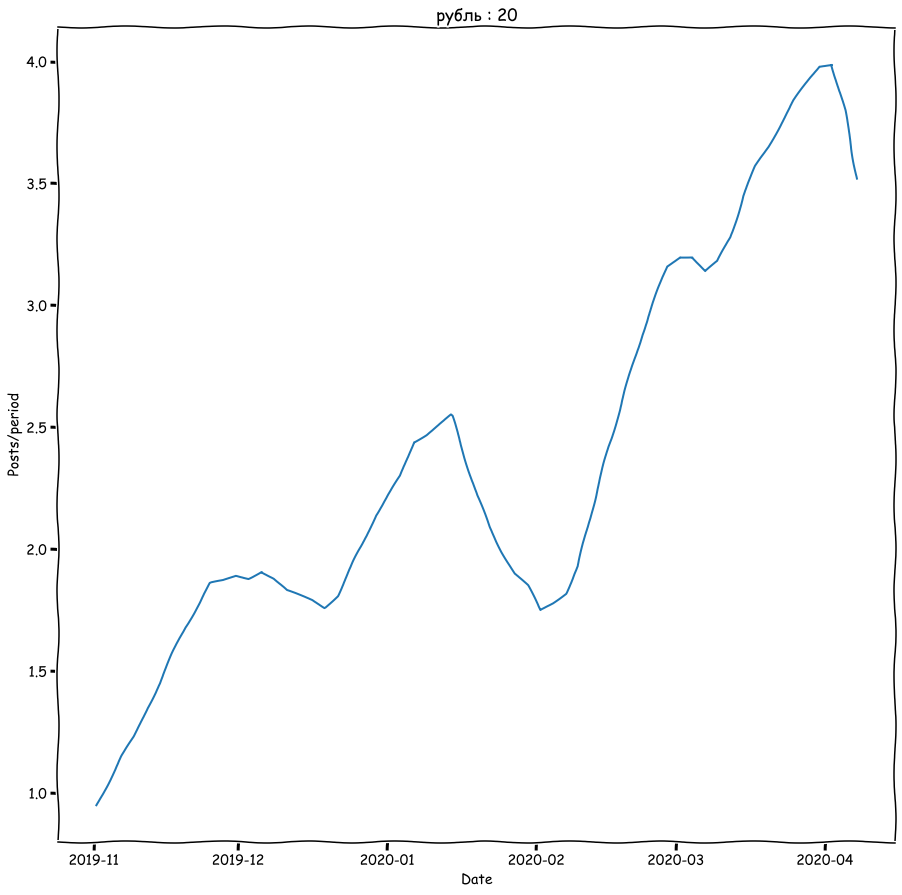

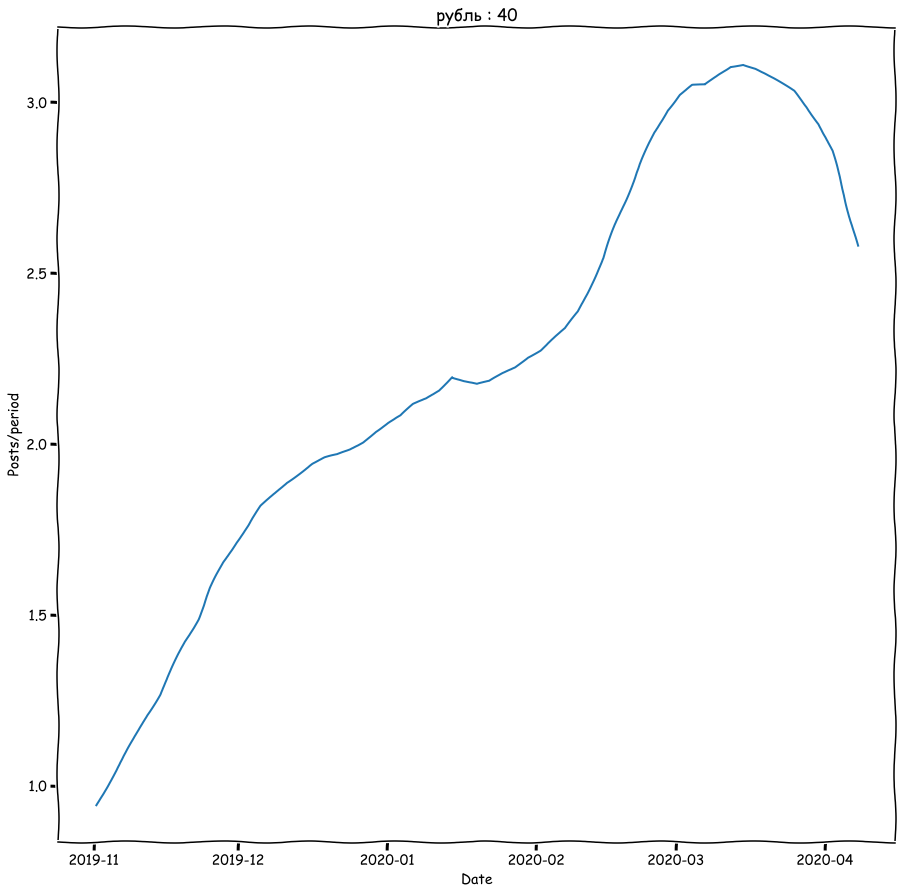

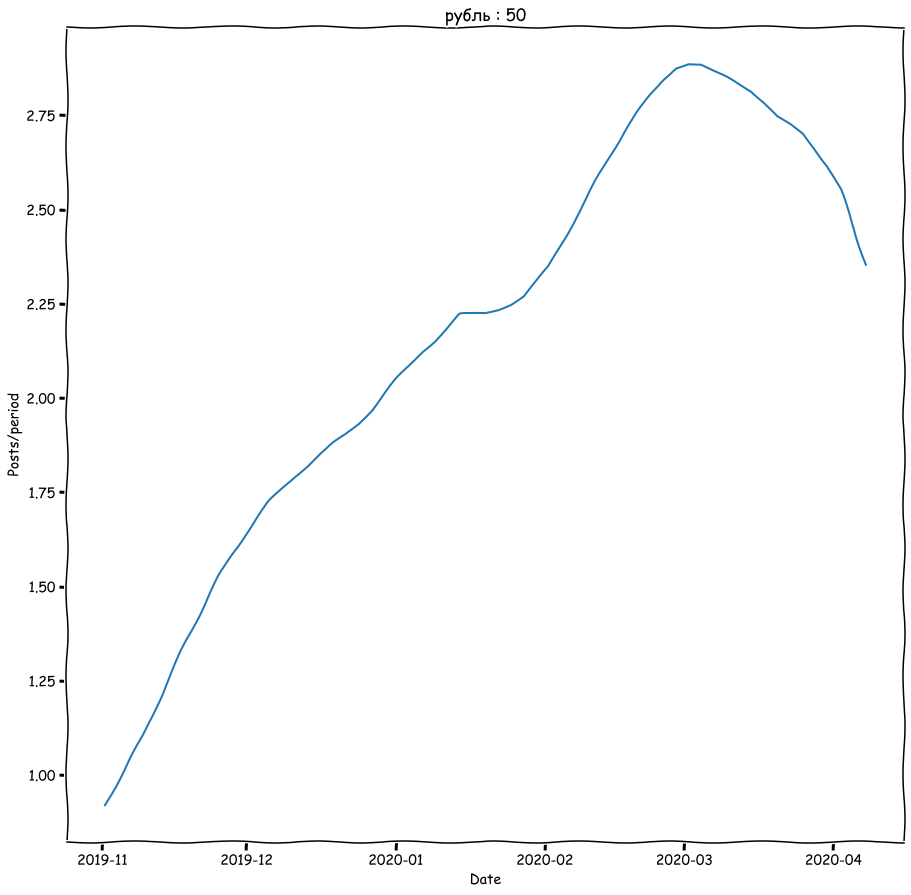

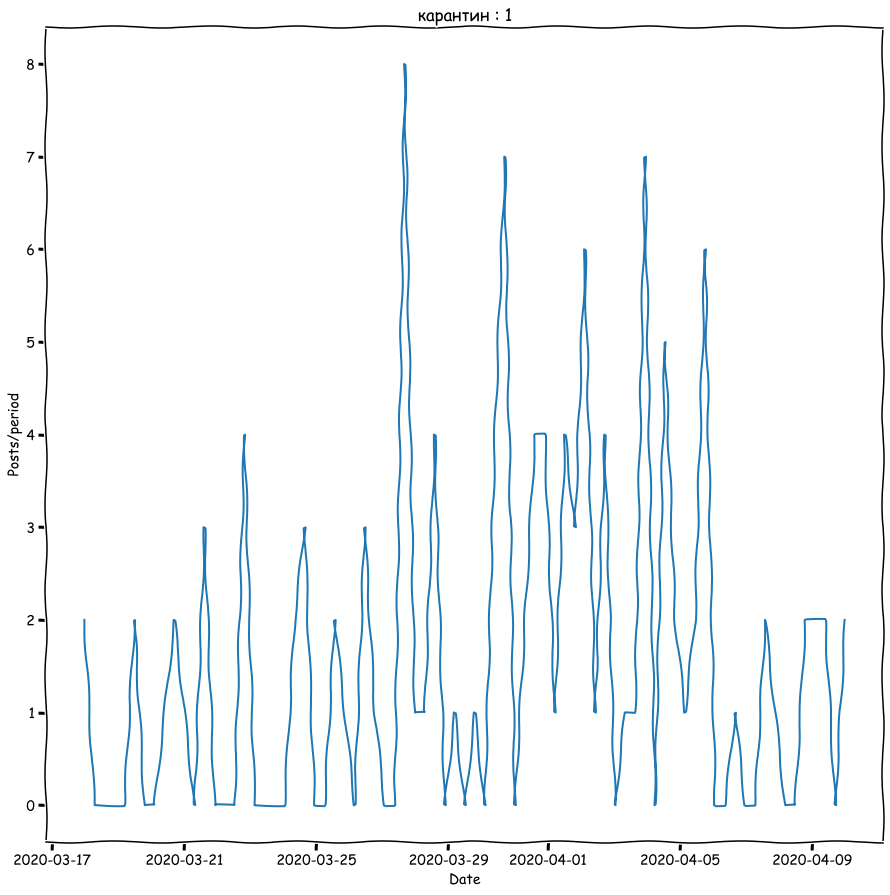

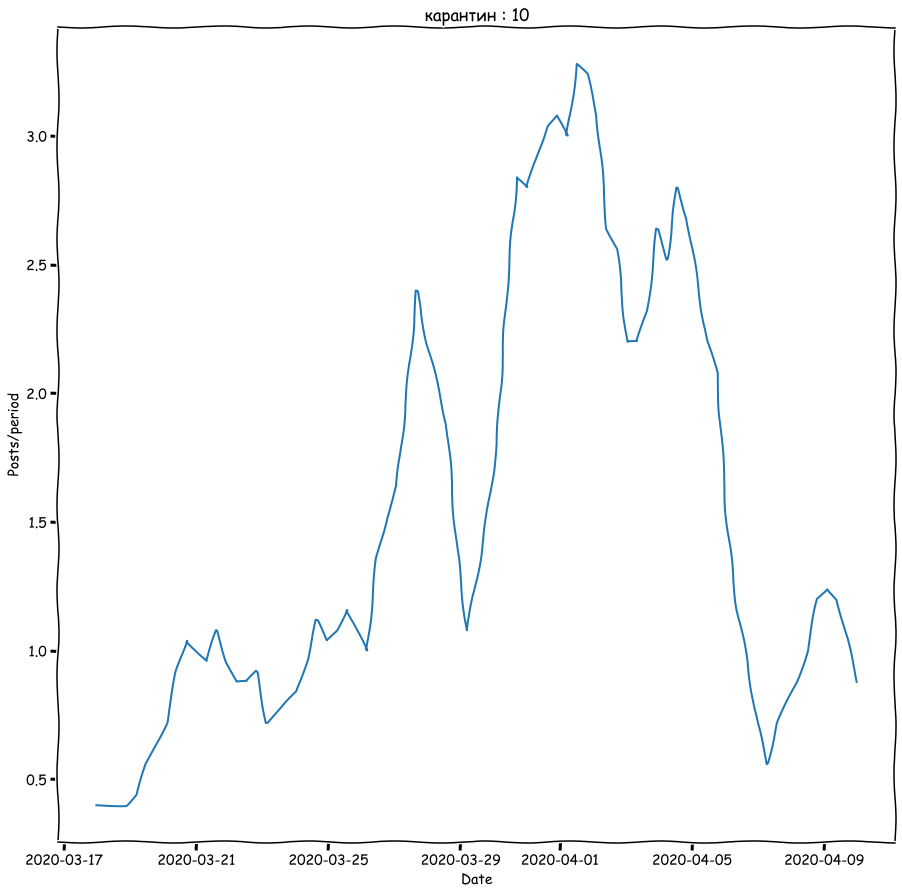

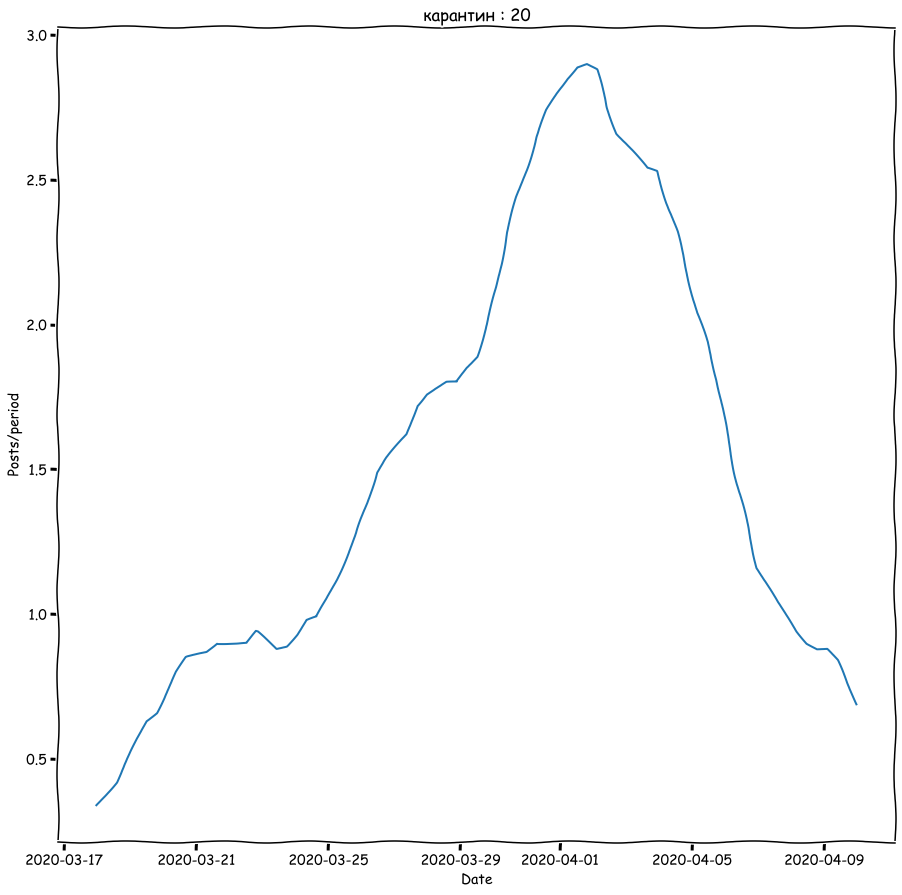

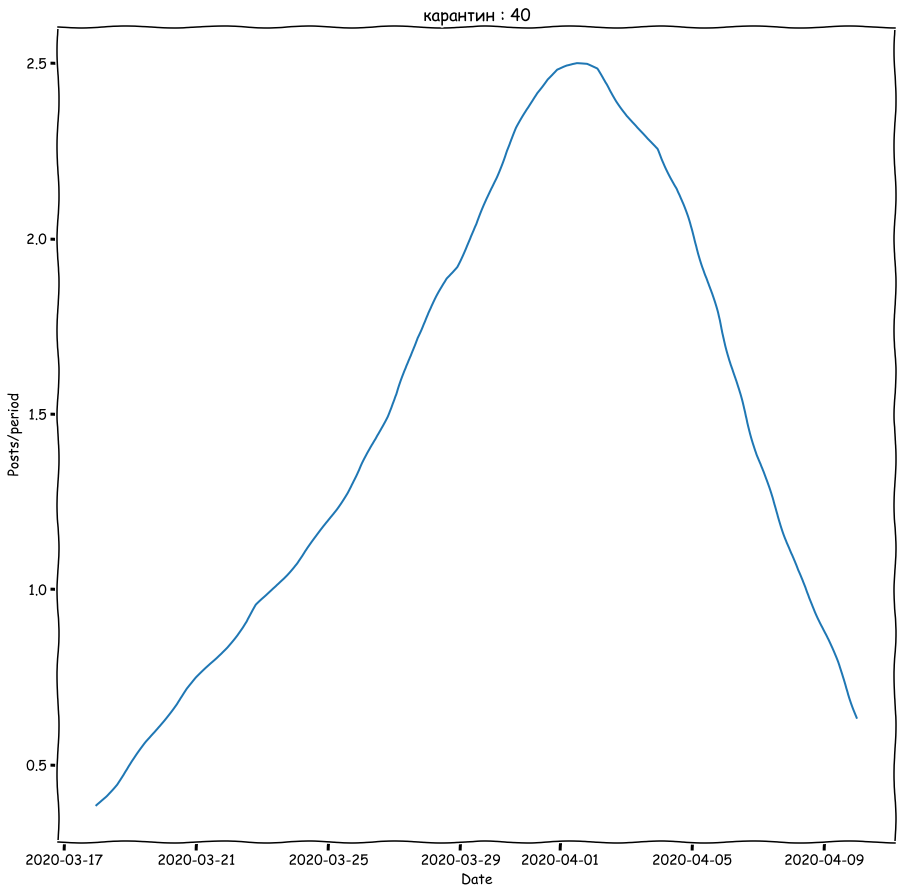

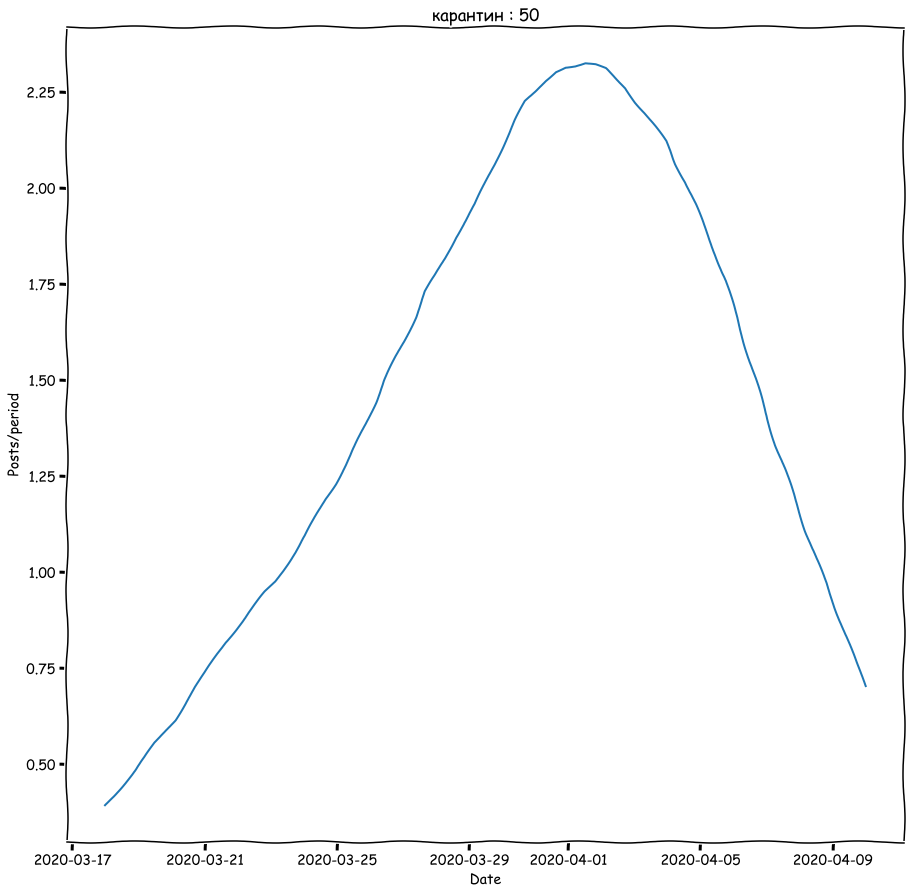

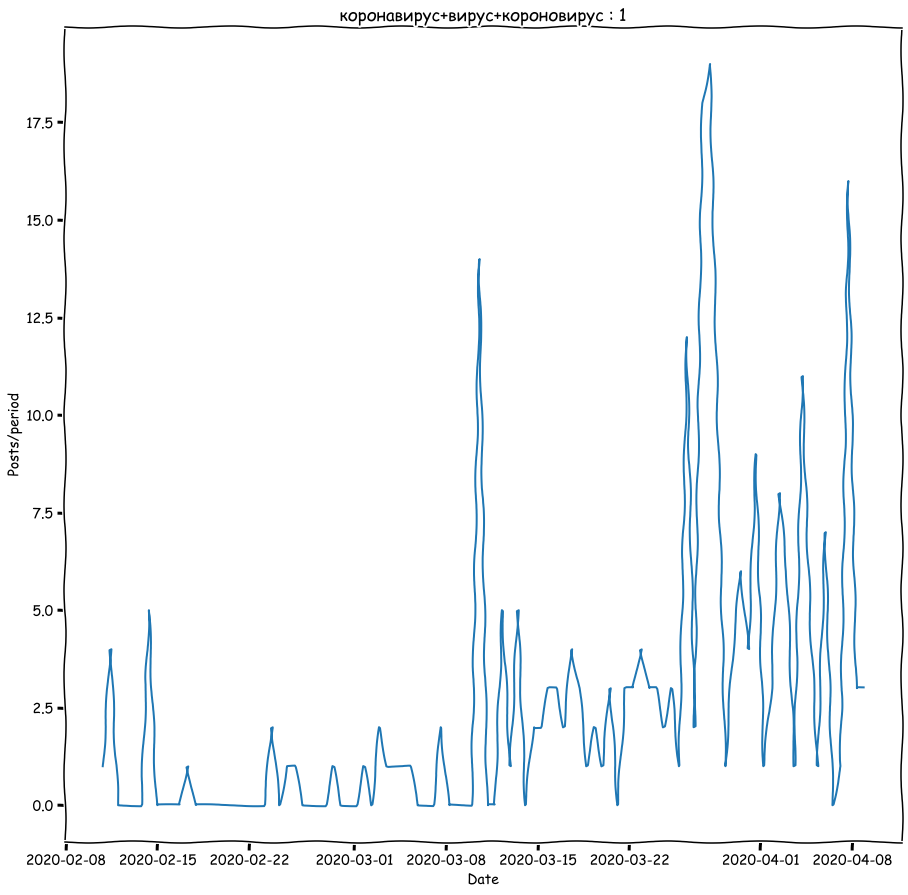

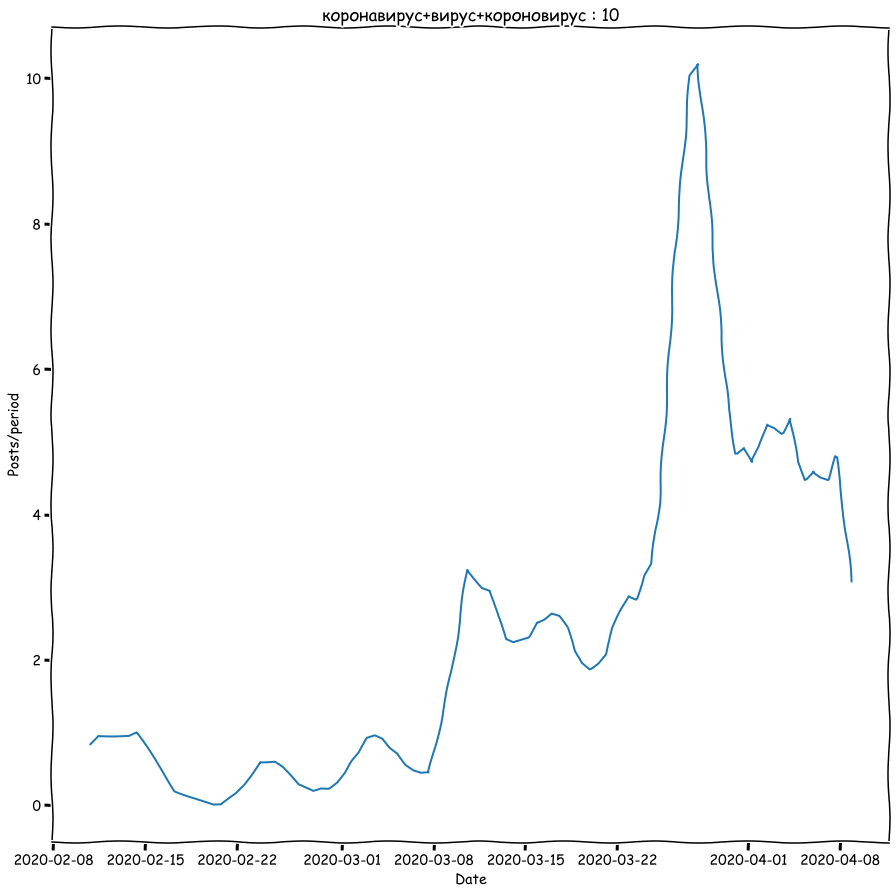

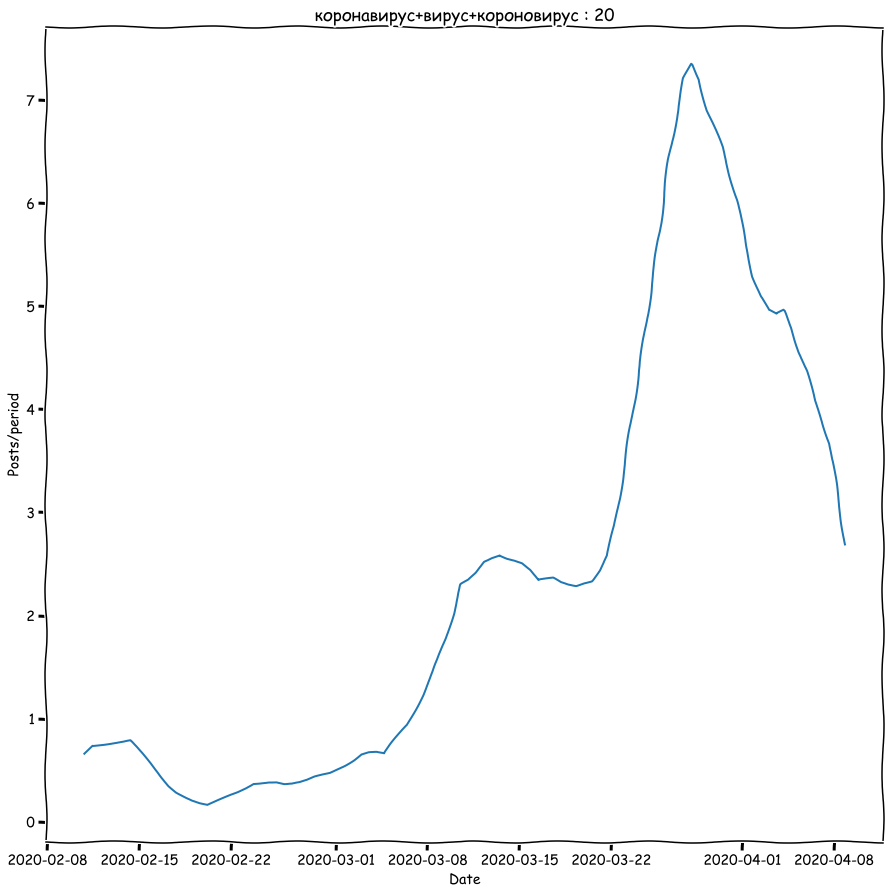

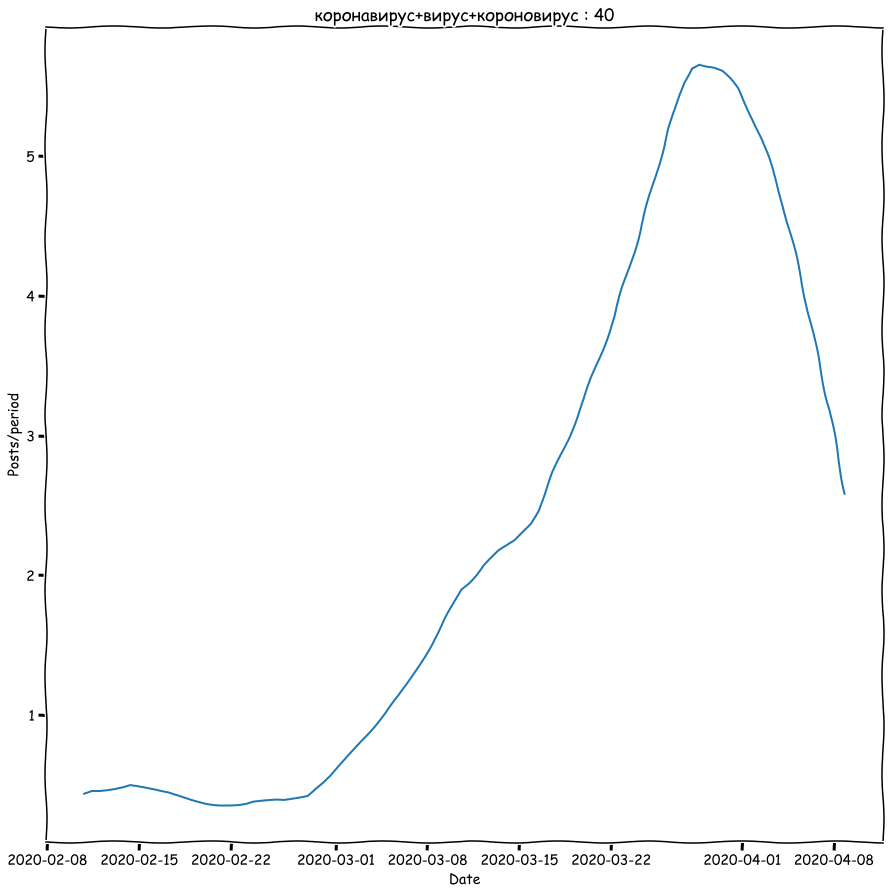

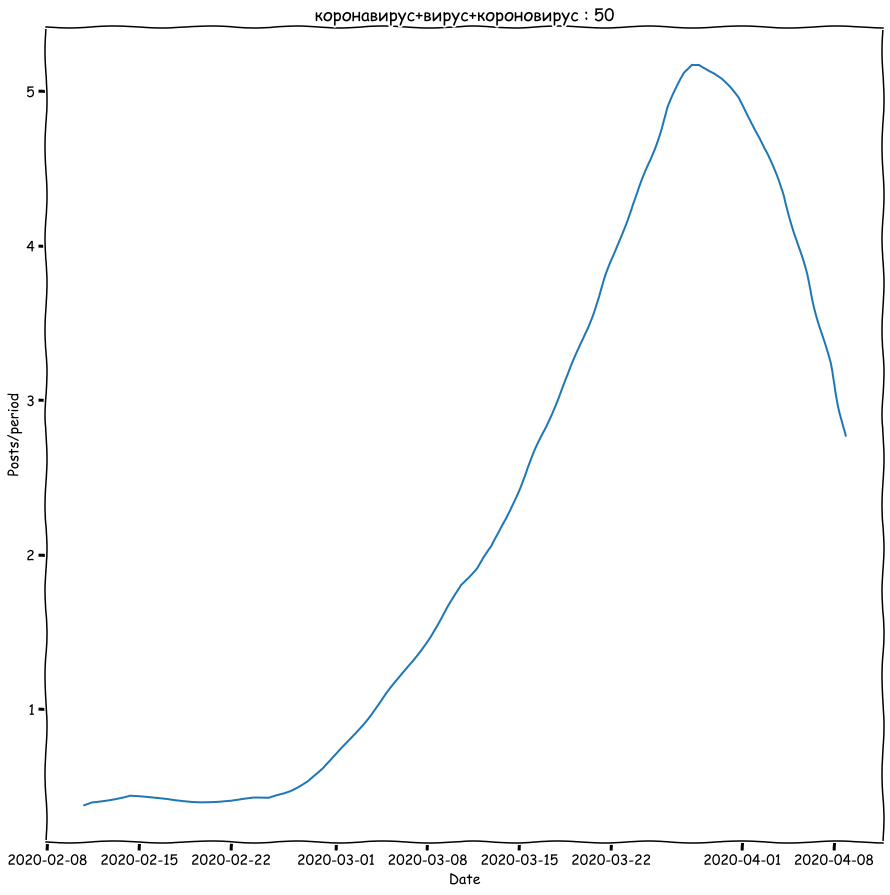

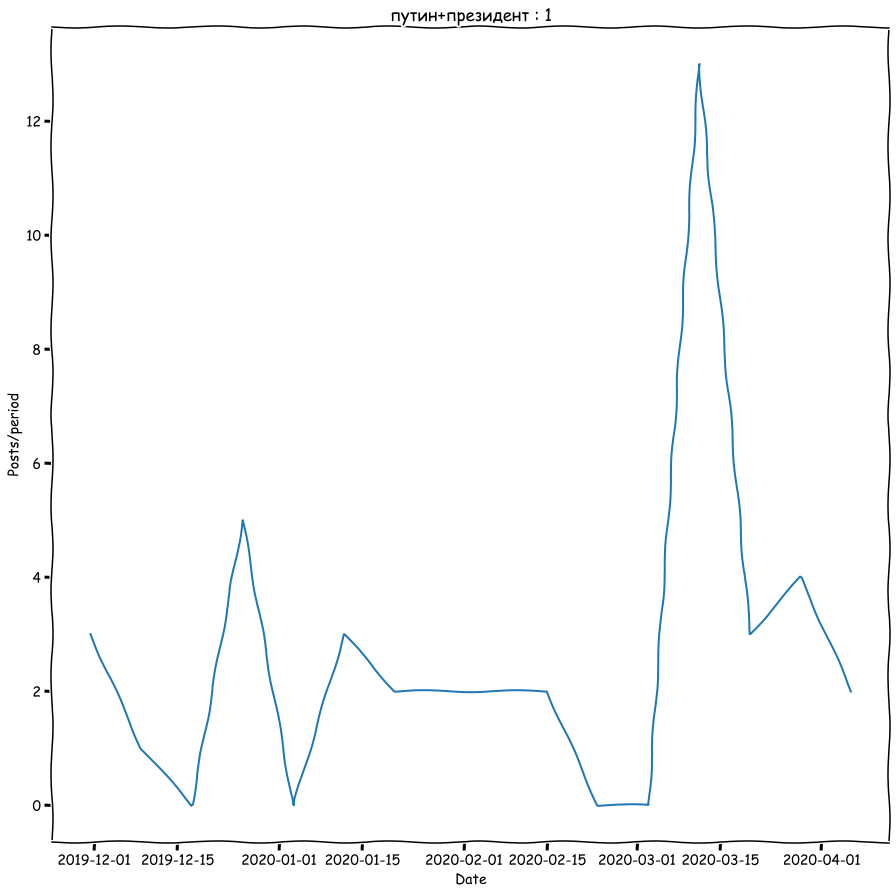

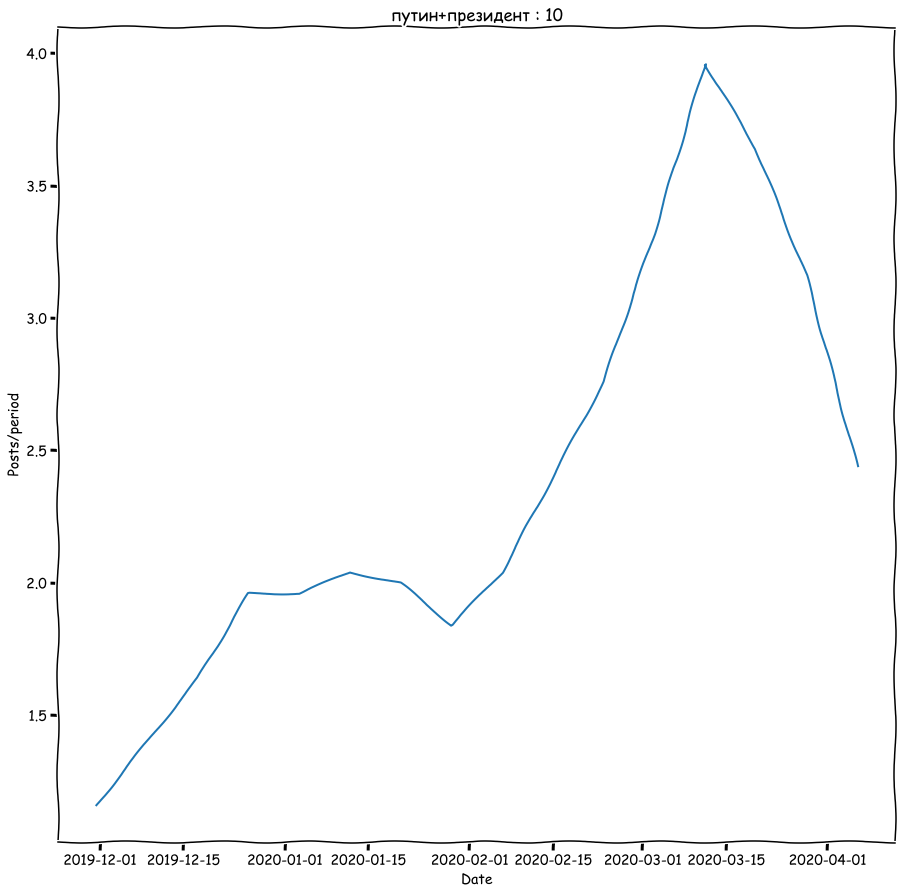

AssertionError: (16, 19)

In [156]:

for ks in "новый", "когда", "рубль", "карантин", ("коронавирус", "вирус", "короновирус"), ("путин", "президент"):
    if not isinstance(ks, tuple):
        ks = (ks, )
    
    for k in ks:
        if k not in words:
            words[k] = Word(k)
            await words[k].download()
    
    word = words[ks[0]]
    for k in ks[1:]:
        word += words[k]
    
    for periods in (1, 10, 20, 40, 50):
        with plt.xkcd():
            ax = get_ax(f"{word.word} : {periods}")
            
            plot(ax, word.slice().to_grid(1 / 3).moving_avg(periods=periods), name=word.word)
        
        # plot(ax, word.slice().integrate().diff().moving_avg(periods=12), name="slice+int")
        
            plt.savefig(f'data/pictures/{word.word}_{periods}.png')
            # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            if periods == 10:
                plt.show()

<ipython-input-146-0f5b4e9fc8db>:4: RuntimeWarning:

divide by zero encountered in true_divide



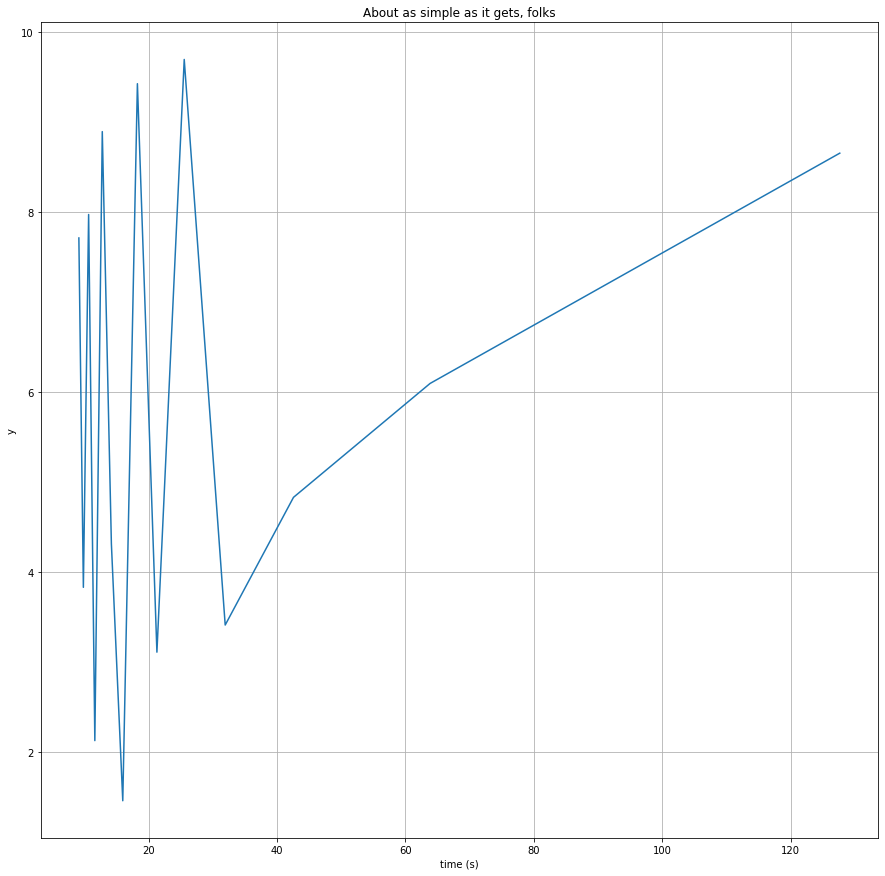

In [146]:
word = words['президент'].slice().to_grid(1).moving_avg(periods=2)
rfft = np.fft.rfft(word.v)

periods = 1 / np.fft.rfftfreq(len(word.v), d=(word.t[1] - word.t[0])) / 60 / 60 / 24
values = np.abs(rfft)

_w = Word("fft", periods[1:], values[1:])

ax = get_ax()

plot(ax, _w, "fsafd")

plt.show()



In [121]:
return
fig = go.Figure()

# for i in range(1, 10):
#     draw_word(fig, word.slice().to_grid(i/2).integrate(), name=f"grid_{i/2}")

draw_word(fig, word.slice().to_grid(0.5).moving_avg(periods=10), name="slice+int")

# for mov in (False,):
#     for i in range(1, 5):
#         draw_word(fig, word.get_smooth(i, mov=mov), name=f'smooth_{i}_{mov}')

fig.show()



SyntaxError: 'return' outside function (<ipython-input-121-36de6cd5c0ff>, line 1)

In [87]:
for k in words:
    print(k)

день
весь
все
мой
год
который
так
свой
человек
такой
очень
рождение
если
кто
мочь
вот
новый
один
себя
или
когда
самый
уже
друг
хороший
только
тот
много
она
жизнь
время
хотеть
можно
просто
чтобы
спасибо
знать
работа
первый
еще
даже
любить
сегодня
раз
нет
каждый
становиться
про
сам
место
другой
сделать
делать
новосибирск
какой
хорошо
ваш
говорить
понимать
без
всегда
тут
давать
большой
город
где
сказать
мир
дело
надо
сейчас
теперь
приходить
ребенок
начинать
после
два
помогать
любовь
чем
писать
смотреть
вопрос
потому
тоже
через
счастие
нужно
твой
что-то
проходить
здесь
думать
получать
красивый
находить
работать
любимый
фото
жить
при
дом
прекрасный
слово
вообще
интересный
пока
оставаться
видеть
нгу
ребята
пусть
его
последний
группа
час
конечно
нужный
любой
потом
утро
ждать
россия
праздник
книга
история
лето
песня
неделя
решать
вечер
ничто
рука
москва
кто-то
хотеться
поэтому
немного
скоро
посмотреть
вид
поздравлять
почему
желать
академгородок
идти
открытка
узнавать
написать
счастливый
крутой

1.0